**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1Jy2ohBJfFKsBiQkqlkjunv8FWRIBSD7k?usp=sharing)
2. Практический ноутбук

# Предсказание будущего кадра с ConvLSTM2D

Архитектура слоя Convolutional LSTM объединяет обработку временных рядов и компьютерное зрение, вводя сверточную рекурентную ячейку в слой LSTM. В примере, который будем разбирать в этом разделе, мы изучим Convultional LSTM модель применительно к прогнозированию следующих кадров на основе серии предыдущих.

## Загрузка библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io # библиотека для работы с различными типами ввода/вывода
import imageio
from IPython.display import Image, display, clear_output
from ipywidgets import widgets, Layout, HBox
# Загрузка датасетов из облака google
import gdown

## Загрузка и работа с данными

Для изучения поставленной перед нами задачи, мы будем использовать движущиеся цифры MNIST - [Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

<p>Мы загрузим этот набор данных, произведем их предобработку и создадим тренировочный и проверочный наборы.

<p>Для прогнозирования следующего кадра наша модель будет использовать предыдущий кадр, который мы назовем <b>f_n</b>, а новый кадр будет называться f_(n + 1). Чтобы модель могла создавать эти прогнозы, нам необходимо обработать данные таким образом, чтобы входные данные были «сдвинуты» относительно выходных, так, что бы входными данными являлся кадр <b>x_n</b>, который используется для прогнозирования кадра y_(n + 1).

In [ ]:
# Закачка и загрузка набора данных.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",  # Указваем путь к набору данных Moving Mnist
)
dataset = np.load(fpath)

In [ ]:
dataset.shape

(20, 10000, 64, 64)

Набор данных имеет формат (n_кадров, n_семплов, ширина_кадра, высота_кадра). Поменяем  местами оси, представляющие количество кадров и количество семплов. Из всего набора (10 000 примеров), оставим только 1000, для нашего эксперимента этого вполне достаточно. Так же необходимо добавить дополнительную размерность к формату кадра. В наборе кадр черно-белый имет формат 64х64, чтобы работать со сверточным слоем, нам необходима еще одна размерность.

In [ ]:
# меняем оси
dataset = np.swapaxes(dataset, 0, 1)
# из 10000 оставляем только 1000 примеров
dataset = dataset[:1000]
# Добавляем канал к размеру кадра так как он черно-белый, что бы он имел формат w,h,c как положено картинке 
dataset = np.expand_dims(dataset, axis=-1)
print(dataset.shape)

(1000, 20, 64, 64, 1)


Разделим данные на обучающий и проверочный наборы, с использованием индексации для оптимального использования памяти

In [ ]:
# Разделяем набор данных на обучающую и проверочную выборки
indexes = np.arange(dataset.shape[0]) # создаем набор индексов
np.random.shuffle(indexes) # перемешиваем индексы
train_index = indexes[: int(0.9 * dataset.shape[0])] # записываем индексы для тернировочного набора
val_index = indexes[int(0.9 * dataset.shape[0]) :] # записываем индексы для проверочного набора
train_dataset = dataset[train_index] # Формиуем тренировочный набор
val_dataset = dataset[val_index] # Формиуем проверочный набор

Нормализуем данные, что бы параметры пикселя были в диапазон 0-1 

In [ ]:
# Нормализуем данные в диапазоне 0-1
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

Создадим вспомогательную функцию для сдвига кадров, где <b>x</b> это кадры с 0 по n-1, а <b>y</b> это кадры с 1 по n.

In [ ]:
train_dataset.shape

(900, 20, 64, 64, 1)

In [ ]:
# Вспомогательная функция
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [ ]:
# Применяем функцию обработки к наборам данных
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Смотрим что получилось
print("Формат Тренировочного набора: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Формат Проверочного набора: " + str(x_val.shape) + ", " + str(y_val.shape))

Формат Тренировочного набора: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Формат Проверочного набора: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


## Визуализация данных

<p>Наши данные состоят из последовательностей кадров, каждый из которых используется для прогнозирования следующего кадра. Давайте посмотрим пример, как выглядят эти последовательности кадров. 

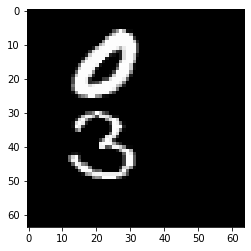

In [ ]:
# Посмотрим как выглядит один кадр
plt.imshow(np.squeeze(dataset[1][0]) , cmap='gray')
plt.show()

In [ ]:
dataset[1][0][:,:,-1].shape

(64, 64)

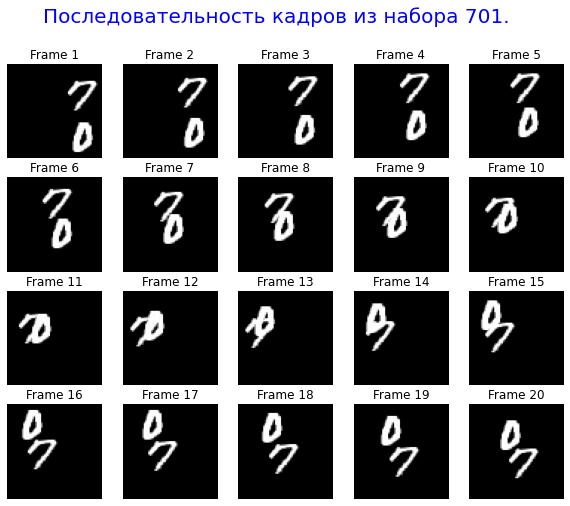

In [ ]:
# Создаем полотно на которую будем выводить изображения
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Выводим каждый кадр из случайного набора данных
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0] # выбираем случайный набор
for idx, ax in enumerate(axes.flat): # проходим по каждому рисунку на полотне
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray") # Выводим последовательно каждый кадр, убираем лишнюю размерность с конца
    ax.set_title(f"Frame {idx + 1}") # выводим номер кадра
    ax.axis("off") # отключаем оси
fig.suptitle(f"Последовательность кадров из набора {data_choice}.", fontsize='20', color='b') # выводим заголовок рисунка
plt.show() # Выводим полотно на экран

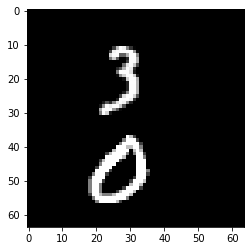

In [ ]:
# Выводим каждый кадр из случайного набора данных
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0] # выбираем случайный набор
for i in range(20): # проходим по каждому рисунку на полотне
    plt.imshow(np.squeeze(train_dataset[data_choice][i]), cmap="gray") # Выводим последовательно каждый кадр, убираем лишнюю размерность с конца
    plt.show() # Выводим полотно на экран
    clear_output(wait=True)

## Модель нейросети
<p>Создавая Convolutional LSTM модель, мы, так же, как и в предыдущих примерах будем использовать слой <b>ConvLSTM2D</b>, который будет принимать на вход тензор (batch_size, num_frames, width, height, channels) и возвращать предсказание в том же формате.

In [ ]:
frame_size = x_train.shape[2:]
print(frame_size)

(64, 64, 1)


> Обратите внимание на интересный вариант записи входного размера <b>*frame_size</b>. <br>Звездочка перед списком означает, - "Рассматривать элементы списка, как позиционные аргументы. Посмотрите на пример ниже

In [ ]:
print(frame_size)
print(*frame_size)


(64, 64, 1)
64 64 1


In [ ]:
# Создаем входной слой по форме размера кадра.
inp = layers.Input(shape=(None, *frame_size))

# Мы построим 3 слоя ConvLSTM2D с пакетной нормализацией,
# с последующим слоем Conv3D для пространственно-временных выходных данных.
x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True,activation="relu")(x)
x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)

# Строим и компилируем модель
model = tf.keras.models.Model(inp, x)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam())

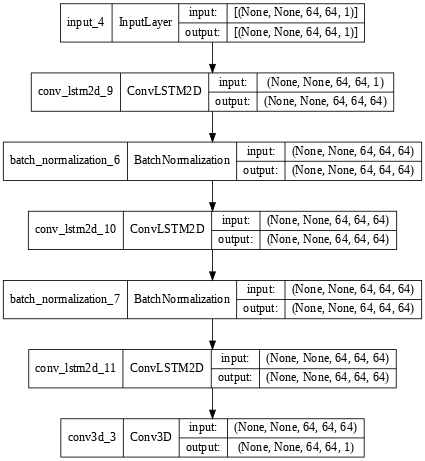

In [ ]:
tf.keras.utils.plot_model(model, dpi=60, show_shapes=True)

## Обучение модели

Теперь у нас есть построенная модель и подготовленный набор данных, можно начинать обучение модели. 
<p> При обучении, так же как и раньше, будем использовать коллбэки, определим их ниже

In [ ]:
# Задаем колбэки для улучшения тренировки
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.7, verbose=1)
model_Checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/model_video_predict.h5', monitor='val_loss', verbose=1, save_best_only=True,
                               mode='min', baseline=0)
callbacks=[early_stopping, reduce_lr, model_Checkpoint]

In [ ]:
# Задаем изменяемые гиперпараметры
epochs = 20
batch_size = 5

# Обучаем модель на тренировочных данных
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=callbacks)

## Визуализация предсказанных кадров

<p>Теперь,  когда наша модель обученна, мы можем сгенерировать последовательность кадров на основе нового видео.
<p> Мы выберем случайный пример из проверочного набора и возьмем первые десять кадров из него. Наша модель предскажет следующие десять кадров, которые мы сможем сравнить с реальными.

In [ ]:
# Блок загрузки весов моделей из облак
model.load_weights(gdown.download('https://storage.yandexcloud.net/aiueducation/Content/extended/gan/l4/model_video_predict.h5', None, quiet=True))

In [ ]:
def compare_frames (original_frames, predicted_frames, data_choice):
  # Выводим на экран оригиральные и сгенерированные (предсказанные) кадры
  fig, axes = plt.subplots(2, 10, figsize=(20, 4))

  # Ввыводим оригинальные кадры
  for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

  # Выводим предсказанные кадры
  new_frames = predicted_frames
  for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx])* 255, cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")
  fig.suptitle(f"Последовательность кадров из набора {data_choice}.", fontsize='15', color='b') # выводим заголовок рисунка
  # Выводим полотно на экран
  plt.show()

### Аппроксимация

In [ ]:
# Выбираем случайный пример из проверочного набора
data_choice = np.random.choice(range(len(val_dataset)), size=1)[0] # выбираем случайный набор кдров
print(data_choice)
example = val_dataset[[data_choice][0]] # генерируем случайный индекс в диапазоне длины проверочной выборки
# Делим последовательность кадров пополам 10 с начала и 10 с конца
frames = example[:10,...] # оставляем первые десять кадров
original_frames = example[10:,...] # оставляем последние 10 кадров

# Предсказываем новый набор из 10 кадров
for _ in range(10):
    # Получаем предсказанные моделью кадры и обрабатываем их
    new_prediction = model.predict(np.expand_dims(frames, axis=0)) # добавляем размерность батча и подаем последовательность из 10 кадров на вход модели
    new_prediction = np.squeeze(new_prediction, axis=0) # убираем лишнюю размерность в начале, которую добавляли для подачи данных в нейронку
    #==
    #plt.imshow(np.squeeze(new_prediction[-1]) , cmap='gray')
    #plt.show()
    #==
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0) # берем последний сгенерированный кадр, добавляем к нему размерность (1, 64, 64, 1)

    # добавляем в конец предсказанные кадры
    frames = np.concatenate((frames, predicted_frame), axis=0) # добавляем к первым 10 кадрам (10, 64, 64, 1) + (1, 64, 64, 1) сгенерированный кадр,
                                                               # повторяем цикл для всех 10 которые надо восстановить.
    print(frames.shape)

64
(11, 64, 64, 1)
(12, 64, 64, 1)
(13, 64, 64, 1)
(14, 64, 64, 1)
(15, 64, 64, 1)
(16, 64, 64, 1)
(17, 64, 64, 1)
(18, 64, 64, 1)
(19, 64, 64, 1)
(20, 64, 64, 1)


После десяти итераций мы сгенерировали десять недостающих кадров и добавили их к framse, в котором хранились первые 10 оригинальных кадров. В итоге, получили ту же размерность последовательности кадров

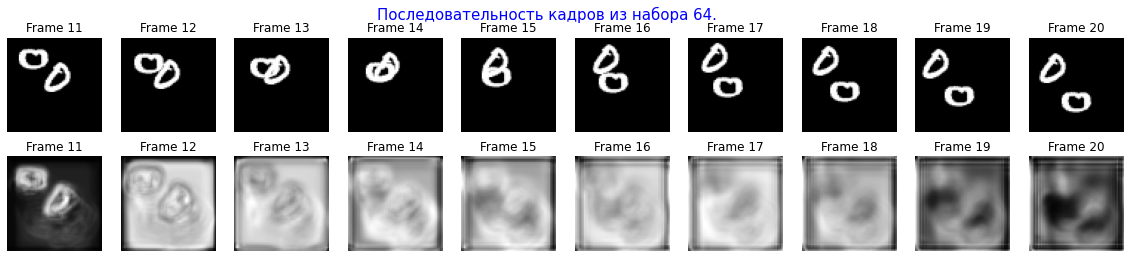

In [ ]:
compare_frames(original_frames, frames[10:], data_choice)

### Покадровая предикция

Разница между аппроксимацией и покадровой предикцией в том, что: в первом случае, мы подаем на вход модели 10 первых оригинальных кадров, а дальше добавляем в последовательность сенерированные кадры; во втором случае мы подаем на вход модели только оригинальные кадры, а сгенерированные записываем в отдельгный массив.

In [ ]:
# Создаем устой массив под новые кадры
new_predictions = np.zeros(shape=(10, *frames[0].shape)) 
# Предсказываем надор из 10 кадров
for i in range(10):
   # Подаем в модель кадр за кадром
   frames = example[: 10 + i + 1]
   new_prediction = model.predict(np.expand_dims(frames, axis=0)) # Выход (1, 20, 64, 64, 1)
   new_prediction = np.squeeze(new_prediction, axis=0) # (20, 64, 64, 1)
   predicted_frame = np.expand_dims(new_prediction[-1], axis=0) # (1, 64, 64, 1)
   # Записываем предсказанные кадры
   new_predictions[i] = predicted_frame # (10, 64, 64, 1)


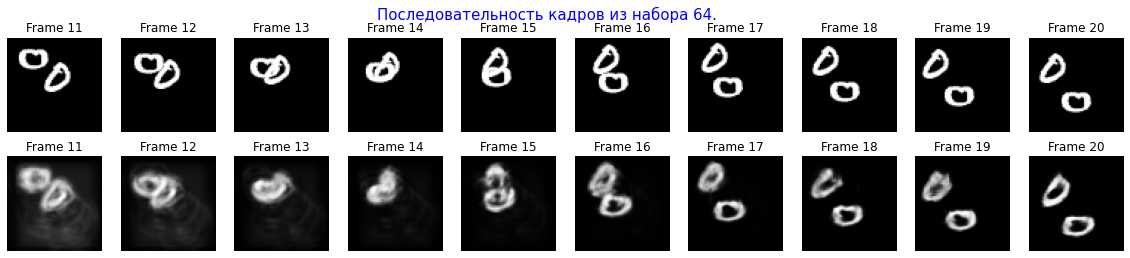

In [ ]:
compare_frames(original_frames, new_predictions, data_choice)

После десяти итераций мы сгенерировали десять новых кадров и записали их в new_predictions

## Предсказание видео потока

<p>В заключении мы выберем несколько примеров из проверочной выборки и создадим GIF анимацию, чтобы посмотреть, как наша модель предсказывает видео кадры


In [ ]:
# Выбираем несколько случайных примеров из проверочной выборки
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Генерируем кадры для каждого примера
predicted_videos = []
for example in examples:
    # Делим последовательность кадров пополам 10 с начала и 10 с конца
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Предсказываем надор из 10 кадров
    for i in range(10):
       # Подаем в модель кадр за кадром
       frames = example[: 10 + i + 1, ...]
       new_prediction = model.predict(np.expand_dims(frames, axis=0)) # Выход (1, 20, 64, 64, 1)
       new_prediction = np.squeeze(new_prediction, axis=0) # (20, 64, 64, 1)
       predicted_frame = np.expand_dims(new_prediction[-1], axis=0) # (1, 64, 64, 1)
       # Записываем предсказанные кадры
       new_predictions[i] = predicted_frame # (10, 64, 64, 1)

    # Создаем и сохраняем GIF анимацию для проверочного и предсказанного набора кадров
    num = 1
    for frame_set in [original_frames, new_predictions]:
        # Создаем GIF последовательность из выбранных видео кадров
        current_frames = np.squeeze(frame_set) # убираем размерность у кадров сзади (64, 64, 1) --> (64, 64)
        current_frames = current_frames[..., np.newaxis] * np.ones(3) # Дабавляем вместо 1 кнала 3 --> (64, 64)-->(64, 64, 3)
        current_frames = (current_frames * 255).astype(np.uint8) # Убираем нормиовку 
        current_frames = list(current_frames) # Переводим из тензор из numpy в список

        # Создаем GIF из наора кадров
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames,'.gif', fps=5) # переводим список кадров в gif изображение с частотой 5 кадров в секунду
            predicted_videos.append(gif.getvalue())
        num+=1

# Показываем видео
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


In [ ]:
# Выбираем несколько случайных примеров из проверочной выборки
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Генерируем кадры для каждого примера
predicted_videos = []
for example in examples:
    # Делим последовательность кадров пополам 10 с начала и 10 с конца
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Предсказываем надор из 10 кадров
    for i in range(10):
        # Получаем кадры от нашей модели и обрабатывавем их
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Записываем предсказанные кадры
        new_predictions[i] = predicted_frame

    # Создаем и сохраняем GIF анимацию для проверочного и предсказанного набора кадров
    num = 1
    for frame_set in [original_frames, new_predictions]:
        # Создаем GIF последовательность из выбранных видео кадров
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Создаем GIF из наора кадров
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, '/content/video_predict'+ str(num) + '.gif', fps=5)
            predicted_videos.append(gif.getvalue())
        num+=1

# Показываем видео
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1Jy2ohBJfFKsBiQkqlkjunv8FWRIBSD7k?usp=sharing)
2. Практический ноутбук